In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from mlmicrophysics.models import DenseNeuralNetwork
from sklearn.ensemble import RandomForestClassifier
from mlmicrophysics.explain import partial_dependence_2d
from mlmicrophysics.data import subset_data_files_by_date, log10_transform, neg_log10_transform, assemble_data_files
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error
from keras.models import save_model
import yaml
from matplotlib.colors import LogNorm
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}
transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform}
import call_collect

Using TensorFlow backend.


# Data Loading

In [2]:
path = "/glade/scratch/dgagne/cam_mp_files_run2_csv/"
#path = "/Users/dgagne/data/cam_mp_files_run2_csv/"
train_files, val_files, test_files = subset_data_files_by_date(path, ".csv", train_date_start=0, train_date_end=8000, 
                                                               test_date_start=8100, test_date_end=16000)

[    0   123   246   369   492   615   738   861   984  1107  1230  1353
  1476  1599  1722  1845  1968  2091  2214  2337  2460  2583  2706  2829
  2952  3075  3198  3321  3444  3567  3690  3813  3936  4059  4182  4305
  4428  4551  4674  4797  4920  5043  5166  5289  5412  5535  5658  5781
  5904  6027  6150  6273  6396  6519  6642  6765  6888  7011  7134  7257
  7380  7503  7626  7749  7872  7995  8118  8241  8364  8487  8610  8733
  8856  8979  9102  9225  9348  9471  9594  9717  9840  9963 10086 10209
 10332 10455 10578 10701 10824 10947 11070 11193 11316 11439 11562 11685
 11808 11931 12054 12177 12300 12423 12546 12669 12792 12915 13038 13161
 13284 13407 13530 13653 13776 13899 14022 14145 14268 14391 14514 14637
 14760 14883 15006 15129 15252 15375 15498 15621 15744 15867 15990 16113
 16236 16359 16482 16605 16728 16851 16974 17097 17220 17343 17466]


In [3]:
input_transforms_yaml = """
  temperature: log10_transform
  RHO_CLUBB_lev: log10_transform
  QC_TAU_in: log10_transform
  NC_TAU_in: log10_transform
  QR_TAU_in: log10_transform
  NR_TAU_in: log10_transform
  """
output_transforms_yaml = """
  qctend_TAU:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  qrtend_TAU:
    0: ["<=", 1e-15, "zero_transform", "None"]
    1: [">", 1e-15, "log10_transform", "StandardScaler"]
  nctend_TAU:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  nrtend_TAU:
    -1: ["<", 0, "neg_log10_transform", "StandardScaler"]
    0: ["==", 0, "zero_transform", "None"]
    1: [">", 0, "log10_transform", "StandardScaler"]
  qctend_MG2:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  qrtend_MG2:
    0: ["<=", 1e-15, "zero_transform", "None"]
    1: [">", 1e-15, "log10_transform", "StandardScaler"]
  nctend_MG2:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  nrtend_MG2:
    -1: ["<", 0, "neg_log10_transform", "StandardScaler"]
    0: ["==", 0, "zero_transform", "None"]
    1: [">", 0, "log10_transform", "StandardScaler"]
"""
input_transforms = yaml.load(input_transforms_yaml)
output_transforms = yaml.load(output_transforms_yaml)

In [4]:
input_transforms

{'temperature': 'log10_transform',
 'RHO_CLUBB_lev': 'log10_transform',
 'QC_TAU_in': 'log10_transform',
 'NC_TAU_in': 'log10_transform',
 'QR_TAU_in': 'log10_transform',
 'NR_TAU_in': 'log10_transform'}

In [5]:
input_scaler = StandardScaler()
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in","temperature", "RHO_CLUBB_lev"]
output_cols = ["qctend_TAU", "qrtend_TAU", "nctend_TAU", "nrtend_TAU", 
               "qctend_MG2", "qrtend_MG2", "nctend_MG2", "nrtend_MG2"]

scaled_input_train,\
    labels_train,\
    transformed_out_train,\
    scaled_out_train,\
    output_scalers =  assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                          output_transforms, input_scaler, subsample=0.01)

/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000123.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000246.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000492.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000615.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000861.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000984.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001230.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001353.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001599.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001722.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001968.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_002091.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_002337.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_002

In [6]:
scaled_input_test,\
    labels_test,\
    transformed_out_test,\
    scaled_out_test,\
    output_scalers_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                             output_transforms, input_scaler, output_scalers=output_scalers,
                                             subsample=0.01)

/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008118.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008241.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008364.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008487.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008610.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008733.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008856.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_008979.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_009102.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_009225.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_009348.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_009471.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_009594.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_009

In [14]:
original_input_train = pd.DataFrame(10 ** input_scaler.inverse_transform(scaled_input_train), 
                                    columns=scaled_input_train.columns)


In [12]:
np.sum(labels_train["nrtend_TAU"] ==-1)

11837

In [82]:
pd_bins = 20

pd_vals = np.zeros((len(input_cols), pd_bins))

for v, var in enumerate(input_cols):
    pd_vals[v] = np.logspace(np.log10(original_input_train[var].min()), np.log10(original_input_train[var].max()), pd_bins)


In [49]:
pd_bins = 20
pd_vals = np.zeros((len(input_cols), pd_bins))
pd_grid_tau = np.zeros((len(input_cols), pd_bins, 5))
for v, var in enumerate(input_cols):
    print(var)
    pd_vals[v] = np.logspace(np.log10(original_input_train[var].min()), np.log10(original_input_train[var].max()), pd_bins)
    train_copy = original_input_train.loc[labels_train["qctend_TAU"] == 1].copy()
    for p, pd_val in enumerate(pd_vals[v]):
        print(p, pd_val)
        train_copy.loc[:, var] = pd_val
        out_vals = np.array(call_collect.call_collect(1800.0, 
                          train_copy["temperature"].values, 
                          train_copy["RHO_CLUBB_lev"].values,
                          train_copy["QC_TAU_in"].values,
                          train_copy["NC_TAU_in"].values,
                          train_copy["QR_TAU_in"].values,
                          train_copy["NR_TAU_in"].values))
        out_vals[0][out_vals[0] > -1e-15] = 0
        print(out_vals.shape)
        pd_grid_tau[v, p, 0] = np.log10(-out_vals[0][out_vals[0] < 0]).mean()
        pd_grid_tau[v, p, 1] = np.log10(-out_vals[1][out_vals[1] < 0]).mean()
        pd_grid_tau[v, p, 2] = np.log10(out_vals[2][out_vals[2] > 0]).mean()
        pd_grid_tau[v, p, 3] = np.log10(out_vals[3][out_vals[3] > 0]).mean()
        pd_grid_tau[v, p, 4] = np.log10(-out_vals[3][out_vals[3]< 0]).mean()
        

QC_TAU_in
0 9.98870663121092e-07
(4, 47941)
1 1.4777031049877366e-06
(4, 47941)
2 2.1860752819263467e-06
(4, 47941)
3 3.2340225327529554e-06
(4, 47941)
4 4.784328256590316e-06
(4, 47941)
5 7.077809951844596e-06
(4, 47941)
6 1.0470726720187918e-05
(4, 47941)
7 1.5490118948486947e-05
(4, 47941)
8 2.2915676385255527e-05
(4, 47941)
9 3.390085162935767e-05
(4, 47941)
10 5.0152032254007045e-05
(4, 47941)
11 7.419360335563978e-05
(4, 47941)
12 0.00010976007414842497
(4, 47941)
13 0.00016237617978089456
(4, 47941)
14 0.00024021506877431088
(4, 47941)
15 0.00035536788304854774
(4, 47941)
16 0.0005257219413701984
(4, 47941)
17 0.0007777392747680939
(4, 47941)
18 0.001150567119074952
(4, 47941)
19 0.0017021188699659895
(4, 47941)
QR_TAU_in
0 7.203059376837877e-16
(4, 47941)
1 3.1664105819625124e-15
(4, 47941)
2 1.3919302131264219e-14
(4, 47941)
3 6.118820247920383e-14
(4, 47941)
4 2.68978723741232e-13
(4, 47941)
5 1.1824101851995296e-12
(4, 47941)
6 5.197786005589841e-12
(4, 47941)
7 2.2849075302

In [69]:
out_var_names = ["QC", "NC", "QR", "NR"]
for o, out_var_name in enumerate(out_var_names):
    fig, axes = plt.subplots(3, 2, figsize=(6, 9))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for a, ax in enumerate(axes.ravel()):
        ax.plot(np.log10(pd_vals[a]), pd_grid_tau[a, :, o], '-')
        ax.set_xlabel(input_cols[a].replace("_", " "))
    fig.suptitle(f"TAU Microphysics Partial Dependence {out_var_name}", fontsize=14, y=0.93)
    plt.savefig(f"tau_partial_dependence_{out_var_name.lower()}.png", bbox_inches="tight", dpi=200)
    plt.close()

In [7]:
print(call_collect.call_collect.__doc__)

qctend_tau,nctend_tau,qrtend_tau,nrtend_tau = collect_step(deltatin,t,rho,qcin,ncin,qrin,nrin,[mgncol])

Wrapper for ``collect_step``.

Parameters
----------
deltatin : input float
t : input rank-1 array('d') with bounds (mgncol)
rho : input rank-1 array('d') with bounds (mgncol)
qcin : input rank-1 array('d') with bounds (mgncol)
ncin : input rank-1 array('d') with bounds (mgncol)
qrin : input rank-1 array('d') with bounds (mgncol)
nrin : input rank-1 array('d') with bounds (mgncol)

Other Parameters
----------------
mgncol : in/output rank-0 array(int,'i'), optional
    Default: len(t)

Returns
-------
qctend_tau : rank-1 array('d') with bounds (mgncol)
nctend_tau : rank-1 array('d') with bounds (mgncol)
qrtend_tau : rank-1 array('d') with bounds (mgncol)
nrtend_tau : rank-1 array('d') with bounds (mgncol)



In [16]:
qctend_tau, nctend_tau, qrtend_tau, nrtend_tau = call_collect.call_collect(1800.0, 
                          original_input_train["temperature"].values, 
                          original_input_train["RHO_CLUBB_lev"].values,
                          original_input_train["QC_TAU_in"].values,
                          original_input_train["NC_TAU_in"].values,
                          original_input_train["QR_TAU_in"].values,
                          original_input_train["NR_TAU_in"].values)

In [65]:
qctend_tau_top, nctend_tau_top, qrtend_tau_top, nrtend_tau_top = call_collect.call_collect(1800.0, 
                          original_input_train["temperature"].values, 
                          original_input_train["RHO_CLUBB_top"].values,
                          original_input_train["QC_TAU_in"].values,
                          original_input_train["NC_TAU_in"].values,
                          original_input_train["QR_TAU_in"].values,
                          original_input_train["NR_TAU_in"].values)

In [26]:
np.count_nonzero(qctend_tau > 0)

10203

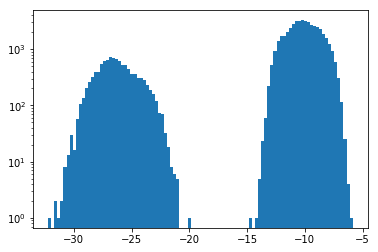

In [45]:
plt.hist(np.log10(-qctend_tau[qctend_tau < 0]), bins=100)
plt.gca().set_yscale("log")

(array([  1.,   0.,   1.,   3.,   1.,   5.,   7.,  17.,  18.,  34.,  58.,
         68.,  98., 138., 221., 240., 406., 490., 580., 706., 778., 782.,
        874., 829., 583., 539., 489., 470., 419., 414., 453., 515., 541.,
        570., 483., 399., 325., 174.,  85.,  29.,  11.,   4.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-15.08140053, -14.67426938, -14.26713822, -13.86000706,
        -13.45287591, -13.04574475, -12.63861359, -12.23148244,
        -11.82435128, -11.41722012, -11.01008897, -10.60295781,
        -10.19582665,  -9.7886955 ,  -9.38156434,  -8.97443318,
         -8.56730203,  -8.16017087,  -7.75303971,  -7.34590856,
         -6.9387774 ,  -6.53164624,  -6.12451509,  -5.71738393,
         -5.31025277,  -4.90312162,  -4.49599046,  -4.0888593 ,
         -3.68172815,  -3.27459699,  -2.86746583,  -2.46033468,
         -2.05320352,  -1.64607236,  -1.23894121,  -0.83181005,
         -0.42467889,  -0.01754774,   0.38958342,   0.79671458,
          1.203845

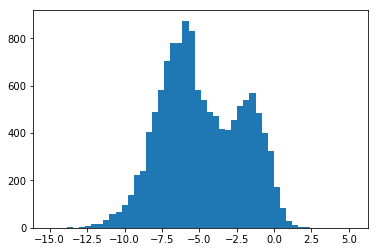

In [44]:
plt.hist(np.log10(-nrtend_tau[nrtend_tau < 0]), bins=50)
#plt.gca().set_yscale("log")

In [90]:
np.min(np.abs(qctend_tau +qrtend_tau))

0.0

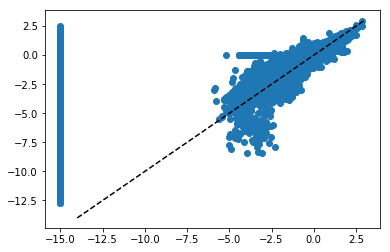

In [16]:
plt.scatter(
log10_transform(nrtend_tau), 
transformed_out_train.loc[:,"nrtend_TAU"])
plt.plot(np.arange(-14, 4),np.arange(-14, 4), 'k--')

In [ ]:
plt.plot(qctend_tau)

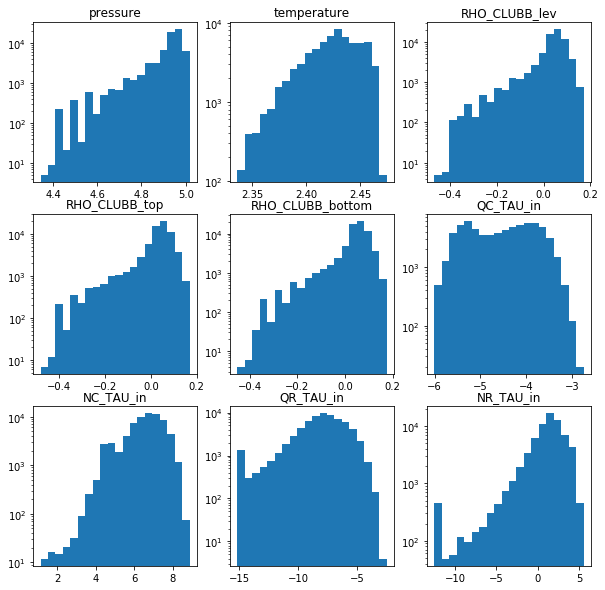

In [242]:
fig, axes = plt.subplots(3,3, figsize=(10, 10))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    ax.set_yscale("log")
    ax.hist(transformed_input_train[input_cols[a]], bins=20)
    ax.set_title(input_cols[a])

# Model Training

In [70]:
dnn_qr_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30,
                                  inputs=len(input_cols), outputs=2,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=40,
                                  batch_size=256, verbose=1, lr=0.001, classifier=True)
dnn_qr = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="relu", epochs=40, 
                         batch_size=256, verbose=1, lr=0.001)
dnn_nc = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="relu", epochs=40, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.001)



In [71]:
dnn_qr_class.fit(scaled_input_train, labels_train["qrtend_TAU"])

Epoch 1/40
67105/67105 [==============================] - 1s 21us/step - loss: 0.9971
Epoch 2/40
67105/67105 [==============================] - 1s 13us/step - loss: 0.3575
Epoch 3/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2783
Epoch 4/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2578
Epoch 5/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2483
Epoch 6/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2431
Epoch 7/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2399
Epoch 8/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2372
Epoch 9/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2342
Epoch 10/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2325
Epoch 11/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.2302
Epoch 12/40
67105/67105 [===========================

In [72]:
dnn_qr.fit(scaled_input_train.loc[labels_train["qrtend_TAU"] == 1], 
           scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, "qrtend_TAU"].values)

Epoch 1/40
47941/47941 [==============================] - 1s 20us/step - loss: 1.2426
Epoch 2/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.4980
Epoch 3/40
47941/47941 [==============================] - 1s 12us/step - loss: 0.3176
Epoch 4/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.2457
Epoch 5/40
47941/47941 [==============================] - 1s 12us/step - loss: 0.2052
Epoch 6/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.1819
Epoch 7/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.1686
Epoch 8/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.1591
Epoch 9/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.1528
Epoch 10/40
47941/47941 [==============================] - 1s 11us/step - loss: 0.1493
Epoch 11/40
47941/47941 [==============================] - 1s 12us/step - loss: 0.1448
Epoch 12/40
47941/47941 [===========================

In [73]:
dnn_nc.fit(scaled_input_train, scaled_out_train.loc[:, "nctend_TAU"])

Epoch 1/40
67105/67105 [==============================] - 1s 17us/step - loss: 0.0971
Epoch 2/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0116
Epoch 3/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0085
Epoch 4/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0075
Epoch 5/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0069
Epoch 6/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0064
Epoch 7/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0062
Epoch 8/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0061
Epoch 9/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0060
Epoch 10/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0059
Epoch 11/40
67105/67105 [==============================] - 1s 11us/step - loss: 0.0058
Epoch 12/40
67105/67105 [===========================

In [63]:
save_model(dnn_nc.model, "dnn_nc.h5")
save_model(dnn_qr.model, "dnn_qr.h5")

In [74]:
dnn_nr_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30,
                                  inputs=len(input_cols), outputs=3,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=40,
                                  batch_size=256, verbose=1, lr=0.005, classifier=True)
dnn_nr_class.fit(scaled_input_train, labels_train["nrtend_TAU"])

Epoch 1/40
67105/67105 [==============================] - 1s 20us/step - loss: 1.3451
Epoch 2/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.6003
Epoch 3/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.4913
Epoch 4/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.4463
Epoch 5/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.4196
Epoch 6/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.4046
Epoch 7/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.3933
Epoch 8/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.3834
Epoch 9/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.3769
Epoch 10/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.3706
Epoch 11/40
67105/67105 [==============================] - 1s 12us/step - loss: 0.3656
Epoch 12/40
67105/67105 [===========================

In [75]:
test_nr_sign = dnn_nr_class.predict(scaled_input_test)

In [76]:

confusion_matrix(labels_test["nrtend_TAU"].values, test_nr_sign)

array([[14467,   414,  2571],
       [   26, 25942,  1992],
       [  161,  1844, 50589]])

In [26]:
confusion_matrix(labels_test["qrtend_TAU"].values, dnn_qr_class.predict(scaled_input_test))

array([[25275,  2722],
       [ 1267, 68742]])

In [77]:
nr_pos_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="relu", epochs=30, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.005)
nr_neg_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="relu", epochs=30, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.005)

In [78]:
pos_sub = labels_train["nrtend_TAU"] == 1
neg_sub = labels_train["nrtend_TAU"] == -1
nr_pos_net.fit(scaled_input_train.loc[pos_sub], scaled_out_train.loc[pos_sub, "nrtend_TAU"])
nr_neg_net.fit(scaled_input_train.loc[neg_sub], scaled_out_train.loc[neg_sub, "nrtend_TAU"])

Epoch 1/30
36104/36104 [==============================] - 1s 26us/step - loss: 0.4133
Epoch 2/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.1668
Epoch 3/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.1055
Epoch 4/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0903
Epoch 5/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0812
Epoch 6/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0799
Epoch 7/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0780
Epoch 8/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0715
Epoch 9/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0705
Epoch 10/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0670
Epoch 11/30
36104/36104 [==============================] - 0s 11us/step - loss: 0.0688
Epoch 12/30
36104/36104 [===========================

In [79]:
nr_pred_values = np.zeros(scaled_input_test.shape[0])
nr_pred_values[test_nr_sign > 0] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(nr_pos_net.predict(scaled_input_test[test_nr_sign > 0]).ravel())
nr_pred_values[test_nr_sign < 0] = -10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(nr_neg_net.predict(scaled_input_test[test_nr_sign < 0]).ravel())

(array([3.1300e+02, 9.5390e+03, 2.3201e+04, 2.3690e+04, 1.2165e+04,
        1.1000e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.7997e+04]),
 array([-14.65470725, -13.18923653, -11.7237658 , -10.25829508,
         -8.79282435,  -7.32735363,  -5.8618829 ,  -4.39641218,
         -2.93094145,  -1.46547073,   0.        ]),
 <a list of 10 Patch objects>)

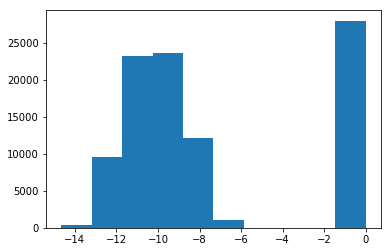

In [31]:
plt.hist(transformed_out_test["qrtend_TAU"])

In [32]:
pred_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols[1:4], dtype=float)
qr_class_preds = dnn_qr_class.predict(scaled_input_test)
pred_tendencies.loc[:, "qrtend_TAU"] = output_scalers["qrtend_TAU"][1].inverse_transform(dnn_qr.predict(scaled_input_test))
pred_tendencies.loc[:, "nctend_TAU"] = output_scalers["nctend_TAU"][1].inverse_transform(dnn_nc.predict(scaled_input_test))
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values


# Partial Dependence Plots

In [80]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [81]:
pd_bins = 20
pd_vals = np.zeros((len(input_cols), pd_bins))
for v, var in enumerate(input_cols):
    print(var, scaled_input_train[var].min(), scaled_input_train[var].max())
    pd_vals[v] = np.linspace( scaled_input_train[var].min(), scaled_input_train[var].max(), pd_bins)

QC_TAU_in -2.096936346054902 2.4981611153877874
QR_TAU_in -3.3437457028786834 2.428363731669629
NC_TAU_in -5.66631854818383 2.453578326666529
NR_TAU_in -5.796029412317201 2.0260639134293554
temperature -3.347520027988209 2.0809592430014168
RHO_CLUBB_lev -6.454774485886658 1.81031090466261


In [84]:
pd_vals_scaled = input_scaler.transform(log10_transform(pd_vals).T).T


In [99]:
pd_output_qr = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_qr[v] = partial_dependence_1d(scaled_input_train.loc[labels_train["qrtend_TAU"] == 1], dnn_qr, v, 
                                            pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [86]:
pd_output_nc = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nc[v] = partial_dependence_1d(scaled_input_train, dnn_nc, v, pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [100]:
pd_output_nr_pos = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_pos[v] = partial_dependence_1d(scaled_input_train.loc[labels_train["nrtend_TAU"] == 1], nr_pos_net, v, pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [101]:
pd_output_nr_neg = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_neg[v] = partial_dependence_1d(scaled_input_train.loc[labels_train["nrtend_TAU"] == -1], nr_neg_net, v, pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [58]:
pd_grid_tau.shape

(6, 20, 4)

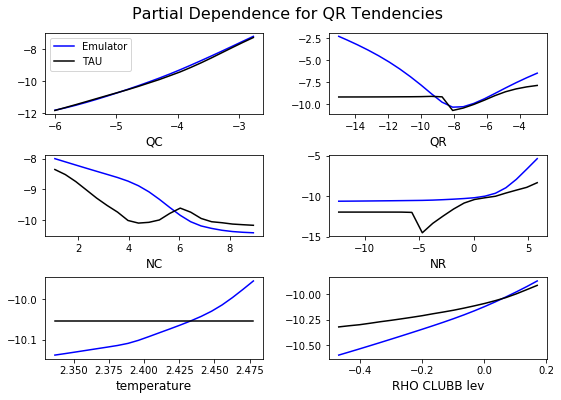

In [113]:
#pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_qr = output_scalers["qrtend_TAU"][1].inverse_transform(pd_output_qr)
fig, axes = plt.subplots(3, 2, figsize=(9, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_qr[a], color='b', label="Emulator")
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 2], 'k-', label="TAU")
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    #ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_qr[a].min(), 1), 
    #                                   np.round(pd_unscaled_qr[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for QR Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_qr.png", dpi=200, bbox_inches="tight")

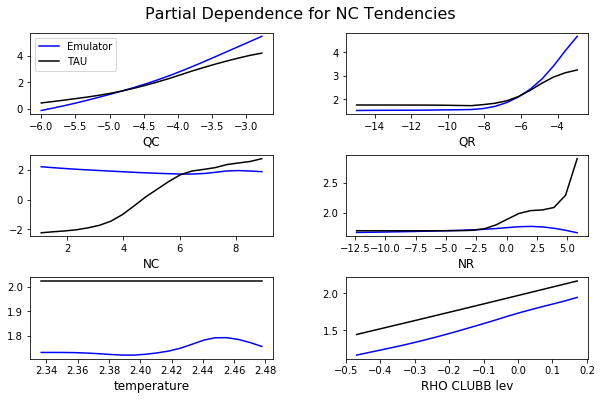

In [112]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nc = output_scalers["nctend_TAU"][1].inverse_transform(pd_output_nc)

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_nc[a], 'b-', label="Emulator")
    
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 1], 'k-', label="TAU")

    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    #ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nc[a].min(), 1), 
    #                                   np.round(pd_unscaled_nc[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for NC Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nc.png", dpi=200, bbox_inches="tight")

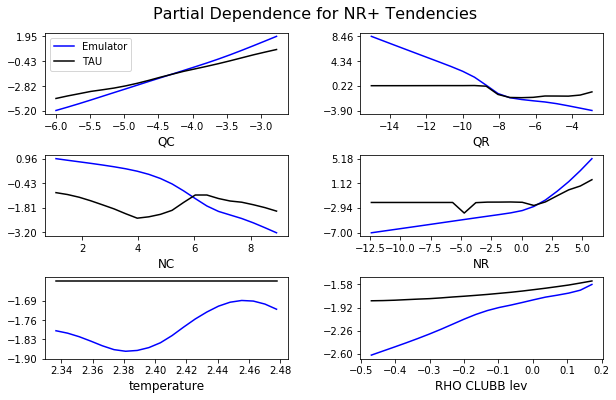

In [109]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nr_pos = output_scalers["nrtend_TAU"][1].inverse_transform(pd_output_nr_pos)
pd_unscaled_nr_neg = output_scalers["nrtend_TAU"][-1].inverse_transform(pd_output_nr_neg)

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
        
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_nr_pos[a], 'b-', label="Emulator")
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 3], 'k-', label="TAU")

    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nr_pos[a].min(), 1), 
                                       np.round(pd_unscaled_nr_pos[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for NR+ Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr_pos.png", dpi=200, bbox_inches="tight")

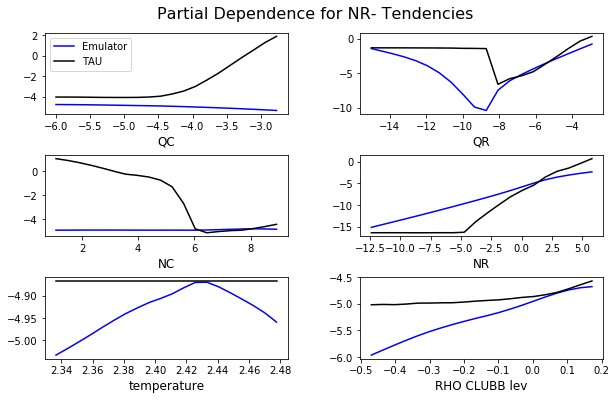

In [115]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nr_pos = output_scalers["nrtend_TAU"][1].inverse_transform(pd_output_nr_pos)
pd_unscaled_nr_neg = output_scalers["nrtend_TAU"][-1].inverse_transform(pd_output_nr_neg)

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):        
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_nr_neg[a], 'b-', label="Emulator")
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 4], 'k-', label="TAU")
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    #ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nr_neg[a].min(), 1), 
    #                                   np.round(pd_unscaled_nr_neg[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for NR- Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr_neg.png", dpi=200, bbox_inches="tight")

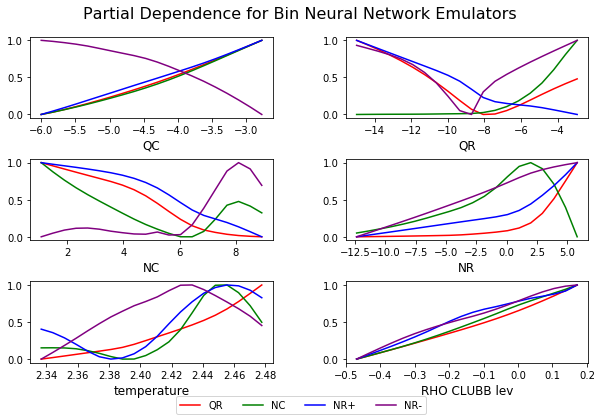

In [119]:
all_pd_out = [pd_output_qr, pd_output_nc, pd_output_nr_pos, pd_output_nr_neg]
pd_names = ["QR", "NC", "NR+", "NR-"]
colors = ['red', 'green', 'blue', 'purple']
fig, axes = plt.subplots(3,2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    for o in range(len(all_pd_out)):
        ax.plot(log10_transform(pd_vals[ a]), 
                (all_pd_out[o][a] - all_pd_out[o][a].min()) / (all_pd_out[o][a].max() - all_pd_out[o][a].min()),
                color=colors[o])
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
plt.figlegend(pd_names, loc='lower center', ncol=4)
plt.suptitle("Partial Dependence for Bin Neural Network Emulators", y=0.95, fontsize=16)
plt.savefig("pdp_all.png", dpi=200, bbox_inches="tight")

In [175]:
pd_grid_nc = partial_dependence_2d(scaled_input_train, dnn_nc, 5, pd_vals[5], 6, pd_vals[6])

KeyboardInterrupt: 

In [ ]:
plt.contourf(pd_unscaled[:, 6], pd_unscaled[:, 5], pd_grid_nc, np.arange(-3, 3.5, .5), cmap="RdBu_r")
plt.xlabel(input_cols[6])
plt.ylabel(input_cols[5])
plt.colorbar()

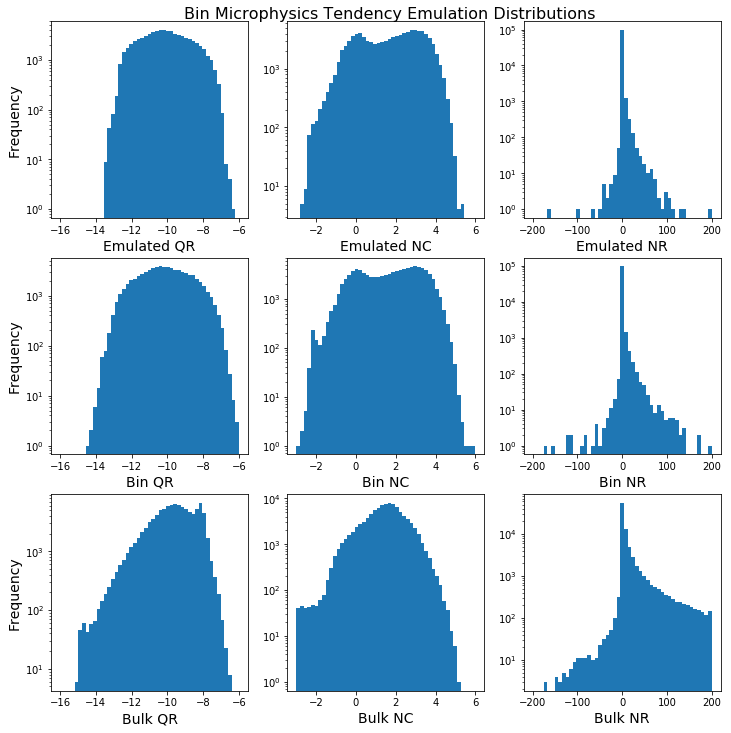

In [205]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(0.03, 0.03, 0.96, 0.96, wspace=0.2)
all_bins = [np.linspace(-16, -6, 50), np.linspace(-3,6, 50), np.linspace(-200, 200, 50)]
axes[0, 0].hist(pred_tendencies.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"],
             bins=all_bins[0])
axes[0, 0].set_xlabel("Emulated QR", fontsize=14)
axes[0, 0].set_yscale("log")
axes[0, 1].hist(pred_tendencies.loc[:, "nctend_TAU"], 
            bins=all_bins[1])
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Emulated NC", fontsize=14)
axes[0, 2].hist(pred_tendencies.loc[:, "nrtend_TAU"], 
             bins=all_bins[2])
axes[0, 2].set_yscale("log")
axes[0, 2].set_xlabel("Emulated NR", fontsize=14)
axes[1, 0].hist(transformed_out_test["qrtend_TAU"],
             bins=all_bins[0])
axes[1, 0].set_yscale("log")
axes[1, 0].set_xlabel("Bin QR", fontsize=14)
axes[1, 1].hist(transformed_out_test["nctend_TAU"], 
            bins=all_bins[1])
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel("Bin NC", fontsize=14)
original_out_test = np.zeros(transformed_out_test["nrtend_TAU"].size)
original_out_test[labels_test["nrtend_TAU"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] > 0, 
                                                                                  "nrtend_TAU"]
original_out_test[labels_test["nrtend_TAU"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] < 0, 
                                                                                  "nrtend_TAU"]
axes[1, 2].hist(original_out_test, 
             bins=all_bins[2])
axes[1, 2].set_yscale("log")
axes[1, 2].set_xlabel("Bin NR", fontsize=14)
axes[2, 0].hist(transformed_out_test["qrtend_MG2"],
               bins=all_bins[0])
axes[2, 0].set_yscale("log")
axes[2, 0].set_xlabel("Bulk QR", fontsize=14)
axes[2, 1].hist(transformed_out_test["nctend_MG2"], 
            bins=all_bins[1])
axes[2, 1].set_yscale("log")
axes[2, 1].set_xlabel("Bulk NC", fontsize=14)
original_out_test = np.zeros(transformed_out_test["nrtend_MG2"].size)
original_out_test[labels_test["nrtend_MG2"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_MG2"] > 0, 
                                                                                  "nrtend_MG2"]
original_out_test[labels_test["nrtend_MG2"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_MG2"] < 0, 
                                                                                  "nrtend_MG2"]
axes[2, 2].hist(original_out_test, 
             bins=all_bins[2])
axes[2, 2].set_yscale("log")
axes[2, 2].set_xlabel("Bulk NR", fontsize=14)
axes[0, 0].set_ylabel("Frequency", fontsize=14)
axes[1, 0].set_ylabel("Frequency", fontsize=14)
axes[2, 0].set_ylabel("Frequency", fontsize=14)
fig.suptitle("Bin Microphysics Tendency Emulation Distributions", y=0.98, fontsize=16)
plt.savefig("nn_bin_hist.png", dpi=200, bbox_inches="tight")

In [192]:
transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"]

0       -11.758728
3       -10.194901
4        -9.364924
9       -13.402578
13      -10.557598
14      -10.289907
16      -11.657069
17       -9.239288
18      -11.521441
19       -9.431602
20       -9.261008
22       -9.468618
23       -9.423866
26       -9.049459
28       -8.015106
29      -10.582174
30       -9.777781
31       -9.862971
34      -10.963488
35      -10.082544
37      -11.568765
38      -11.309095
39       -9.847729
40      -11.847333
42      -10.144269
43      -10.780347
45       -8.915291
48      -10.692613
49      -10.577247
51       -8.435481
           ...    
97976    -8.933398
97977    -8.872843
97978   -10.252928
97979    -9.869181
97980    -9.822349
97981    -8.684698
97982   -10.227599
97983   -11.365665
97984    -9.880169
97985    -9.555189
97986   -11.378923
97987   -10.096209
97988   -10.491423
97989   -11.941214
97990   -10.785126
97991   -13.017644
97992   -13.018031
97993   -13.017515
97994   -13.020953
97995   -13.021616
97996   -13.021560
97997   -11.

In [206]:
rmses = np.zeros(3)
rmses[0] = np.sqrt(mean_squared_error(transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"], 
                                      pred_tendencies.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"]))
rmses[1] = np.sqrt(mean_squared_error(transformed_out_test["nctend_TAU"], 
                                      pred_tendencies.loc[:, "nctend_TAU"]))
original_out_test = np.zeros(transformed_out_test["nrtend_TAU"].size)
original_out_test[labels_test["nrtend_TAU"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] > 0, 
                                                                                  "nrtend_TAU"]
original_out_test[labels_test["nrtend_TAU"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] < 0, 
                                                                                  "nrtend_TAU"]
rmses[2] = np.sqrt(mean_squared_error(original_out_test, 
                                      pred_tendencies.loc[:, "nrtend_TAU"]))
r2s = np.zeros(3)
r2s[0] = r2_score(transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"], 
                  pred_tendencies.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"])
r2s[1] = r2_score(transformed_out_test["nctend_TAU"], 
                  pred_tendencies.loc[:, "nctend_TAU"])
r2s[2] = r2_score(original_out_test, 
                  pred_tendencies.loc[:, "nrtend_TAU"])

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


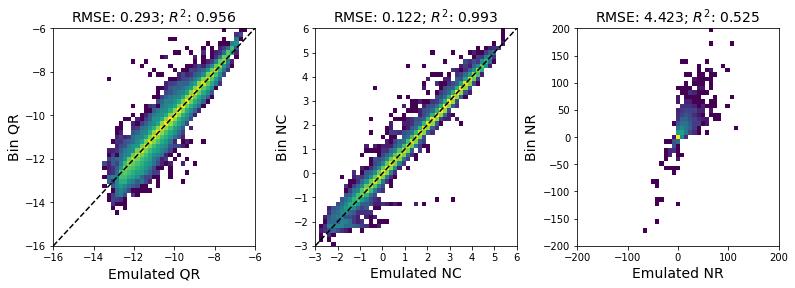

In [208]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(pred_tendencies["qrtend_TAU"], 
               transformed_out_test["qrtend_TAU"],
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Emulated QR", fontsize=14)
axes[0].set_ylabel("Bin QR", fontsize=14)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[0], r2s[0]), fontsize=14)
axes[1].hist2d(pred_tendencies["nctend_TAU"], 
               transformed_out_test["nctend_TAU"],
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Emulated NC", fontsize=14)
axes[1].set_ylabel("Bin NC", fontsize=14)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[1], r2s[1]), fontsize=14)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(pred_tendencies["nrtend_TAU"], 
               original_out_test,
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Emulated NR", fontsize=14)
axes[2].set_ylabel("Bin NR", fontsize=14)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[2], r2s[2]), fontsize=14)
#axes[2].set_xticks(np.arange(-400, 500, 100))
#axes[2].set_yticks(np.arange(-400, 500, 100))
#axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bin_hist2d.png", dpi=200, bbox_inches="tight")

In [93]:
def inverse_nr(nr_labels, nr_vals):
    inverse_vals = np.zeros(nr_vals.size)
    inverse_vals[nr_labels > 0] = 10 ** nr_vals[nr_labels > 0]
    inverse_vals[nr_labels < 0] = -10 ** nr_vals[nr_labels < 0]
    return inverse_vals

In [95]:
rmses_bulk = np.zeros(3)
rmses_bulk[0] = np.sqrt(mean_squared_error(transformed_out_test["qrtend_TAU"], 
                                           transformed_out_test["qrtend_MG2"]))
rmses_bulk[1] = np.sqrt(mean_squared_error(transformed_out_test["nctend_TAU"], 
                                           transformed_out_test["nctend_MG2"]))
rmses_bulk[2] = np.sqrt(mean_squared_error(inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]), 
                                           inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"])))
r2s_bulk = np.zeros(3)
r2s_bulk[0] = r2_score(transformed_out_test["qrtend_TAU"], 
                       transformed_out_test["qrtend_MG2"])
r2s_bulk[1] = r2_score(transformed_out_test["nctend_TAU"], 
                       transformed_out_test["nctend_MG2"])
r2s_bulk[2] = r2_score(inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]), 
                       inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"]))

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


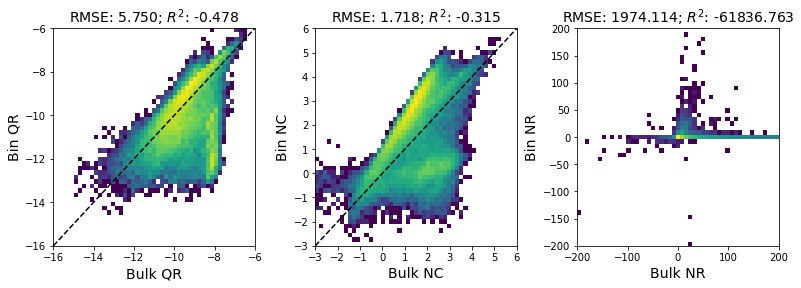

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(transformed_out_test["qrtend_MG2"], 
               transformed_out_test["qrtend_TAU"],
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Bulk QR", fontsize=14)
axes[0].set_ylabel("Bin QR", fontsize=14)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[0], r2s_bulk[0]), fontsize=14)
axes[1].hist2d(transformed_out_test["nctend_MG2"], 
               transformed_out_test["nctend_TAU"],
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Bulk NC", fontsize=14)
axes[1].set_ylabel("Bin NC", fontsize=14)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[1], r2s_bulk[1]), fontsize=14)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"]), 
               inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]),
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Bulk NR", fontsize=14)
axes[2].set_ylabel("Bin NR", fontsize=14)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[2], r2s_bulk[2]), fontsize=14)
#axes[2].set_xticks(np.arange(-400, 500, 100))
#axes[2].set_yticks(np.arange(-400, 500, 100))
#axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bulk_hist2d.png", dpi=200, bbox_inches="tight")